In [25]:
import importlib  
imageprocessing = importlib.import_module("JV-ImagesProcessingFunctions")
import pandas as pd
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import cv2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Model
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Conv1D, Dropout
import gc
from ipynb.fs.full.SIFT_to_Features import SIFT_nparray_to_Features
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
#Simplifies adding a layer
def Convolution(input_tensor,filters):

    x = layers.Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same', activation = 'relu')(input_tensor)

    return x

def Convolution1D(input_tensor,filters):

    x = layers.Conv1D(filters=filters,kernel_size=(3),padding = 'same', activation = 'relu')(input_tensor)

    return x

#Simple CNN model
#Conv stands for neural network layers of (x,y). x standing for the input layers and y standing for how many filter layers there are
#maxp is a pooling layer that reduces the number of nodes of the next layer
#flatten changes the previous layer to a 1 dimensional layer
#dense layers have each node connected to every node in the previous layer. In this case, we have 3 dense layers of differing weights representing
#age, gender, and race. While all previous layers have collected features, dense layers calculate based on these collected features.
#They then send their calculations to the final dense layer to determine classification
#Binary Crossentropy = Classifies based on a binary value
#Sparse Categorical Crossentropy = Classifies based on an integer value with more than 2 possible values
def Simplemodel(input_shape,column):
  losstype = ""
  outputn = 0
  if(column == 'age'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 9
  if(column == 'gender'):
    losstype = "binary_crossentropy"
    outputn = 1
  if(column == 'race'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 5


  inputs = Input((input_shape))

  conv_1= Convolution(inputs,32)

  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)

  conv_2 = Convolution(maxp_1,64)

  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)

  conv_3 = Convolution(maxp_2,64)

  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)

  conv_4 = Convolution(maxp_3,64)

  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)

  conv_5 = Convolution(maxp_4,64)

  flatten= Flatten() (conv_5)

  dense_1= Dense(64,activation='relu')(flatten)

  output_1= Dense(outputn,activation="sigmoid",name='out')(dense_1)

  model = Model(inputs=[inputs], outputs=[output_1])

  model.compile(loss=[losstype], optimizer="Adam",

  metrics=["accuracy"])

  return model

def Simplemodel1D(input_shape,column):
  losstype = ""
  outputn = 0
  if(column == 'age'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 9
  if(column == 'gender'):
    losstype = "binary_crossentropy"
    outputn = 1
  if(column == 'race'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 5

  inputs = Input((input_shape))

  conv_1= Convolution1D(inputs,32)

  maxp_1 = MaxPooling1D(pool_size = 2) (conv_1)

  conv_2 = Convolution1D(maxp_1,64)

  maxp_2 = MaxPooling1D(pool_size = 2) (conv_2)

  conv_3 = Convolution1D(maxp_2,64)

  maxp_3 = MaxPooling1D(pool_size = 2) (conv_3)

  conv_4 = Convolution1D(maxp_3,64)

  maxp_4 = MaxPooling1D(pool_size = 2) (conv_4)

  conv_5 = Convolution1D(maxp_4,64)

  flatten= Flatten() (conv_5)

  dense_1= Dense(64,activation='relu')(flatten)

  output_1= Dense(outputn,activation="sigmoid",name='out')(dense_1)

  model = Model(inputs=[inputs], outputs=[output_1])

  model.compile(loss=[losstype], optimizer="Adam",

  metrics=["accuracy"])

  return model

In [4]:
# Get data and convert for model
data = np.load('../data/raw/UnbalancedRaw/npimagearrays.npy',allow_pickle=True)
filelabels = pd.read_csv('../data/raw/UnbalancedRaw/npimagefilelabels.csv').loc[:,['file','age']]

X_train, X_test, y_train, y_test = train_test_split(data, filelabels, test_size=0.33, random_state=42)
y_testnp = np.asarray(y_test.loc[:,'age'])

y_trainnp = np.asarray(y_train.loc[:,'age'])
if 'data' in globals():
    del data

In [5]:
if 'filelabels' in globals():
    del filelabels

In [12]:
def robertsSobelEdges(imagesArray):
    from skimage import color
    from skimage import filters

    """
    returns two numpy arrays with pictures in black and white and with the edges define using Roberts filter
    on the first one and the Sobel filter on the second one. The images are in black and white
    """
    sobel_ = []
    for image in imagesArray:
        grayImg = color.rgb2gray(image)
        edge_sobel = filters.sobel(grayImg)
        sobel_.append(edge_sobel)
    return np.array(sobel_)

def SelectMask(nparraytrain,nparraytest,select = 0):
    """
    No mask option Select = [1< or >10]
    """
    X_train_mask = nparraytrain
    X_test_mask = nparraytest
    """
    Sobel filter on image picture channel
    """
    if(select == 1):
        X_train_mask = imageprocessing.sobelFilterTypes(nparraytrain)[0]
        X_test_mask = imageprocessing.sobelFilterTypes(nparraytest)[0]
    """
    Sobel filter on image picture hsv
    """
    if(select == 2):
        X_train_mask = imageprocessing.sobelFilterTypes(nparraytrain)[1]
        X_test_mask = imageprocessing.sobelFilterTypes(nparraytest)[1]
    """
    returns two numpy arrays with pictures in black and white and with the edges define using Roberts filter
    """
    if(select == 3):
        X_train_mask = imageprocessing.robertsSobelEdges(nparraytrain)[0]
        X_test_mask = imageprocessing.robertsSobelEdges(nparraytest)[0]
    """
    returns two numpy arrays with pictures in black and white and with the edges define using Sobel filter
    """
    if(select == 4):
        X_train_mask = robertsSobelEdges(nparraytrain)
        X_test_mask = robertsSobelEdges(nparraytest)
        X_train_mask = cv2.normalize(X_train_mask, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        X_test_mask = cv2.normalize(X_test_mask, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    """
    This fucntion increases the exposure of each picture and it returns a numpy
    array of the modified images. The images are in color
    """
    if(select == 5):
        X_train_mask = imageprocessing.exposure_(nparraytrain)
        X_test_mask = imageprocessing.exposure_(nparraytest)

    """
    This function gamma corrects the image
    """
    if(select == 6):
        X_train_mask = imageprocessing.gammaLogaritmictCorrection(nparraytrain)[0]
        X_test_mask = imageprocessing.gammaLogaritmictCorrection(nparraytest)[0]
    """
    This function logarithmic corrects the image
    """
    if(select == 7):
        X_train_mask = imageprocessing.gammaLogaritmictCorrection(nparraytrain)[1]
        X_test_mask = imageprocessing.gammaLogaritmictCorrection(nparraytest)[1]
    """
    This function rescales the image
    """
    if(select == 8):
        X_train_mask = imageprocessing.histogramEqualizer(nparraytrain)[0]
        X_test_mask = imageprocessing.histogramEqualizer(nparraytest)[0]
    """
    This function equalizes the image
    """
    if(select == 9):
        X_train_mask = imageprocessing.histogramEqualizer(nparraytrain)[1]
        X_test_mask = imageprocessing.histogramEqualizer(nparraytest)[1]
    """
    This function adapthis the image
    """
    if(select == 10):
        X_train_mask = imageprocessing.histogramEqualizer(nparraytrain)[2]
        X_test_mask = imageprocessing.histogramEqualizer(nparraytest)[2]
    return X_train_mask,X_test_mask

In [10]:
def Preprocessnparrays(X_train,
                       X_test,
                       y_train,
                       y_test,
                       mask = 0,
                       sift = False,
                       vocab = 200,
                       pca = False,
                       n_components = 200 ,
                       rfs = False,
                       n_estimators = 20):
    X_train, X_test = SelectMask(X_train,X_test,select = mask)
    if(sift):
        X_train, X_test = SIFT_nparray_to_Features(X_train,X_test,nvocab = vocab)
        if(pca):
            pcax = PCA(n_components = n_components)
            pcax.fit(X_train)
            X_train = pcax.transform(X_train)
            X_test = pcax.transform(X_test)
        if(rfs):
            selector = SelectFromModel(RandomForestClassifier(n_estimators = n_estimators))
            selector.fit(X_train, y_train)
            X_train = X_train[:,selector.get_support()]
            X_test = X_test[:,selector.get_support()]
    else:
        if(pca or rfs):
            X_train = X_train.reshape(len(X_train),200*200*3)
            X_test = X_test.reshape(len(X_test),200*200*3)
            if(pca):
                pcax = PCA(n_components = n_components)
                pcax.fit(X_train)
                X_train = pcax.transform(X_train)
                X_test = pcax.transform(X_test)
            if(rfs):
                selector = SelectFromModel(RandomForestClassifier(n_estimators = n_estimators))
                selector.fit(X_train, y_train)
                X_train = X_train[:,selector.get_support()]
                X_test = X_test[:,selector.get_support()]
    return X_train,X_test,y_train,y_test

In [31]:
conmatries = []
histories = []

In [43]:
for i in [0]:
    for j in [False]:
        for k in [False]:
            for l in [False]:
                print(str(i) + str(j) + str(k) + str(l))
                X_train_new,X_test_new,y_train_new,y_test_new = Preprocessnparrays(X_train[:7000],
                                                                                   X_test[:3000],
                                                                                   y_trainnp[:7000],
                                                                                   y_testnp[:3000],
                                                                                   mask =i,
                                                                                   sift = j,
                                                                                   vocab = 200,
                                                                                   pca = k,
                                                                                   n_components = 200 ,
                                                                                   rfs = l,
                                                                                   n_estimators = 20)
                
                #Creating the model
                Type = 'age'
                ModelType = 'RF'
                Modelsimple = ''
                History = ''
                conmatrix = ''
                val_accuracy = 0
                if(ModelType == 'NN'):
                    if(len(X_train_new.shape)==3):
                        X_train_new = tf.expand_dims(X_train_new, axis=-1)
                        X_test_new = tf.expand_dims(X_test_new, axis=-1)
                        Modelsimple=Simplemodel(X_train_new[0].shape,Type)
                    elif(len(X_train_new.shape)==2):
                        X_train_new = tf.expand_dims(X_train_new, axis=-1)
                        X_test_new = tf.expand_dims(X_test_new, axis=-1)
                        Modelsimple=Simplemodel1D(X_train_new[0].shape,Type)
                    else:
                        Modelsimple=Simplemodel(X_train_new[0].shape,Type)
                    
                    if(Type == 'age'):
                       y_test_new = y_test_new - 1
                       y_train_new = y_train_new - 1
                    History = Modelsimple.fit(X_train_new,y_train_new,validation_data=(X_test_new,y_test_new),epochs=5)
                    val_accuracy = History.history['val_accuracy']
                    ypred = Modelsimple.predict(X_test_new)
                    conmatrix = confusion_matrix(np.argmax(ypred, axis=-1),y_test_new)
                if(ModelType == 'SVM'):
                    Modelsimple = SVC(kernel = 'linear', C=1.0, random_state=42, verbose = True)
                    Modelsimple.fit(X_train_new, y_train_new)
                    y_test_new_predict = Modelsimple.predict(X_test_new)
                    val_accuracy = accuracy_score(y_test_new, y_test_new_predict)
                    conmatrix = confusion_matrix(y_test_new_predict,y_test_new)
                if(ModelType == 'RF'):
                    reshape_X_train = np.reshape(X_train_new,(len(X_train_new),200*200*3))
                    reshape_X_test= np.reshape(X_test_new,(len(X_test_new),200*200*3))
                    Modelsimple=RandomForestClassifier()
                    Modelsimple.fit(reshape_X_train, y_train_new)
                    y_test_new_predict = Modelsimple.predict(reshape_X_test)
                    val_accuracy = accuracy_score(y_test_new, y_test_new_predict)
                    conmatrix = confusion_matrix(y_test_new_predict,y_test_new)
                
                histories.append(val_accuracy)
                conmatries.append(conmatrix)

0FalseFalseFalse


In [35]:
histories

[0.444]

In [44]:
histories

[0.444, 0.48133333333333334, 0.5493333333333333]

In [7]:
X_train_mask = imageprocessing.robertsSobelEdges(X_train[:2500])[1]
X_test_mask = imageprocessing.robertsSobelEdges(X_test[:500])[1]

In [24]:
X_train_mask_converted = X_train_mask *255
X_train_mask_converted = np.array(X_train_mask_converted.astype(int))

In [25]:
X_test_mask_converted = X_train_mask *255
X_test_mask_converted =

In [27]:
X_test_mask_converted.shape

(500, 200, 200)

In [8]:
X_train, X_test = SIFT_nparray_to_Features(X_train_mask,X_test_mask,nvocab = 200)

In [21]:
conmatries[0]

array([[ 176,   25,    3,    0,    2,    4,    0,    1,    0],
       [  28,   39,   17,    9,    7,   11,    0,    1,    0],
       [   1,    6,    6,    1,    3,    4,    0,    0,    0],
       [   0,    2,    5,    6,   10,    2,    0,    2,    1],
       [   1,    7,   15,   18,   46,   43,   10,   13,    1],
       [   6,    8,   11,    7,  120, 1133,  283,  112,    3],
       [   0,    2,    2,    1,    3,   89,  134,   73,    3],
       [   0,    4,    1,    0,    3,   42,   67,  260,   43],
       [   0,    0,    0,    0,    0,    1,    1,   22,   40]],
      dtype=int64)

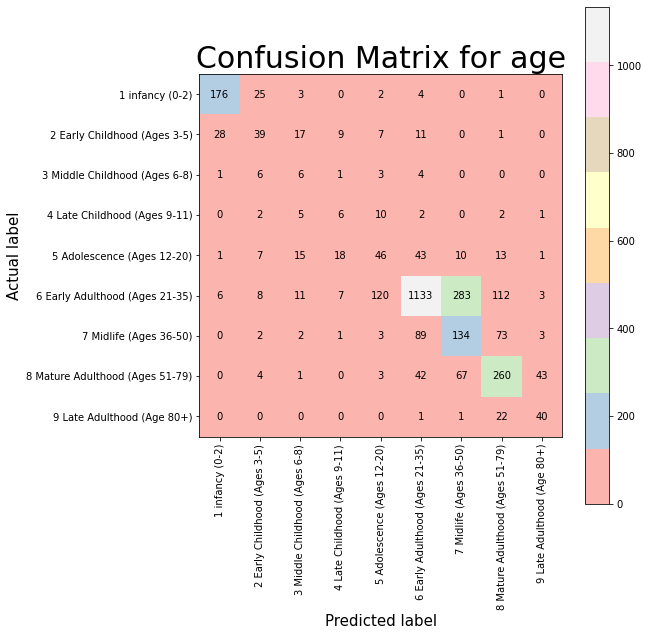

In [23]:
plt.figure(figsize=(9,9))
plt.imshow(conmatries[0], interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix for age', size = 30)
plt.colorbar()
tick_marks = np.arange(9)
plt.xticks(tick_marks, ["1 infancy (0-2)", "2 Early Childhood (Ages 3-5)", "3 Middle Childhood (Ages 6-8)", "4 Late Childhood (Ages 9-11)", "5 Adolescence (Ages 12-20)", "6 Early Adulthood (Ages 21-35)", "7 Midlife (Ages 36-50)", "8 Mature Adulthood (Ages 51-79)", "9 Late Adulthood (Age 80+)"], rotation=90, size = 10)
plt.yticks(tick_marks, ["1 infancy (0-2)", "2 Early Childhood (Ages 3-5)", "3 Middle Childhood (Ages 6-8)", "4 Late Childhood (Ages 9-11)", "5 Adolescence (Ages 12-20)", "6 Early Adulthood (Ages 21-35)", "7 Midlife (Ages 36-50)", "8 Mature Adulthood (Ages 51-79)", "9 Late Adulthood (Age 80+)"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = conmatries[0].shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(conmatries[0][x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

In [ ]:
LabelEncoder().fit_transform(y)
oversample = RandomOverSampler()
X3, y3 = oversample.fit_resample(X3, y3)